In [1]:
import numpy as np
import pandas as pd

import tifffile as tiff
import cv2
import shapely
from shapely import wkt
from shapely import affinity

import random

import matplotlib.pyplot as plt
%matplotlib inline

# 截图图像大小
IMG_WIDTH = 1024
IMG_HEIGHT = 1024

# 滑动窗口大小，即模型输入size
SLIDING_WIDTH = 256
SLIDING_HEIGHT = 256

In [103]:
def show(img):
    plt.figure()
    ax = plt.subplot(111)
    ax.imshow(img, cmap='gray')
    plt.show()
    
def stretch_n(bands, lower_percent=5, higher_percent=95):
    out = np.zeros_like(bands)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)

def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    mins = np.percentile(matrix, 5, axis=0)
    maxs = np.percentile(matrix, 95, axis=0) - mins

    matrix = (matrix - mins[None, :]) / maxs[None, :]
#     matrix = (matrix - mins) / maxs
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)

    return matrix

In [50]:
TRAIN_CLASS = 7 # Water way
DATA_DIR = '/input/DSTL/'

grid_sizes = pd.read_csv('{}/grid_sizes.csv'.format(DATA_DIR))
grid_sizes.columns = ['ImageId','Xmax','Ymin']

train_wkt = pd.read_csv('{}/train_wkt_v4.csv'.format(DATA_DIR))
train_wkt = train_wkt[train_wkt.MultipolygonWKT!='MULTIPOLYGON EMPTY']
train_wkt = train_wkt[train_wkt.ClassType==TRAIN_CLASS]

_img_id_set1 = set([img_id for img_id in grid_sizes.ImageId])
_img_id_set2 = set([img_id for img_id in train_wkt.ImageId])
class_image_ids = _img_id_set1.intersection(_img_id_set2)

## Mask处理

In [104]:
def get_scalers(w, h, x_max, y_min):
    w = w * (w / (w + 1))
    h = h * (h / (h + 1))
    return w / x_max, h / y_min

# w, h是我们希望得到的大小，x_max, y_min是一个放大因子(除以它就是实际大小)，get_scalers得到要扩大的倍数
def get_mask(img_id, polygons_text, w, h, x_max, y_min, w_pos, h_pos):
    x_scaler, y_scaler = get_scalers(w, h, x_max, y_min)

    polygons = wkt.loads(polygons_text)
    polygons_scaled = affinity.scale(polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
    
    mask = np.zeros((w, h), np.uint8)
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons_scaled]
    interiors = [int_coords(pi.coords) for poly in polygons_scaled for pi in poly.interiors]
    
    cv2.fillPoly(mask, exteriors, 1)
    cv2.fillPoly(mask, interiors, 0)
    
    w_start = int((IMG_WIDTH - SLIDING_WIDTH) * w_pos)
    w_end = w_start + SLIDING_WIDTH
    h_start = int((IMG_HEIGHT - SLIDING_HEIGHT) * h_pos)
    h_end = h_start + SLIDING_HEIGHT
    
    mask = mask[w_start:w_end, h_start:h_end]
    mask = np.expand_dims(mask, axis=2)
    return mask

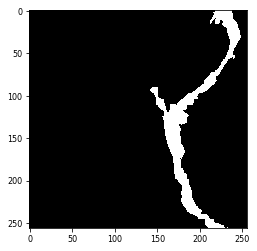

In [79]:
# Trying draw a mask
try_polygons = 'MULTIPOLYGON (((0.007887999999999999 -0.009042, 0.007856 -0.009024000000000001, 0.007844 -0.009011999999999999, 0.007866 -0.009017000000000001, 0.007898000000000001 -0.009029000000000001, 0.007913 -0.009042, 0.007887999999999999 -0.009042)), ((0.0076 -0.008850999999999999, 0.007617 -0.008848, 0.007626 -0.008862999999999999, 0.007631 -0.008888999999999999, 0.00762 -0.008879, 0.0076 -0.008850999999999999)), ((0.007114 -0.008201, 0.007111 -0.008194, 0.007121 -0.008194, 0.007138 -0.008194999999999999, 0.007148 -0.008201999999999999, 0.007165 -0.008225, 0.007178 -0.008238000000000001, 0.007164 -0.008241, 0.007153 -0.008234999999999999, 0.007138 -0.008215999999999999, 0.007114 -0.008201)), ((0.005005 -0.007075, 0.005109 -0.007075, 0.00513 -0.007098, 0.005163 -0.00711, 0.005217 -0.007112, 0.005244 -0.007093, 0.005279 -0.007086, 0.005309 -0.007061, 0.005344 -0.007023, 0.00539 -0.006978, 0.005422 -0.006955, 0.005466 -0.006917, 0.005508 -0.006869, 0.005555 -0.006856, 0.005575 -0.006825, 0.005591 -0.006782, 0.005592 -0.006756, 0.005609 -0.006741, 0.005654 -0.006712, 0.005673 -0.006687, 0.005664 -0.00666, 0.005671 -0.006646, 0.005713 -0.006629, 0.005733 -0.006617, 0.005777 -0.006564, 0.005815 -0.006533, 0.005843 -0.006499, 0.005882 -0.006464, 0.005906 -0.006459, 0.005957 -0.006418, 0.006014 -0.006332, 0.006061 -0.006317, 0.006121 -0.006231, 0.006159 -0.006201, 0.006241 -0.006099, 0.006267 -0.006062, 0.006338 -0.005985, 0.00645 -0.005888, 0.006488 -0.005829, 0.006538 -0.005789, 0.006631 -0.005849, 0.006668 -0.005853, 0.006704 -0.005877, 0.006732 -0.00591, 0.006772 -0.005958, 0.006791 -0.00599, 0.006791 -0.006025, 0.00679 -0.006053, 0.006784 -0.006089, 0.00674 -0.006123, 0.006694 -0.006167, 0.006655 -0.006202, 0.006627 -0.006235, 0.006589 -0.006278, 0.00657 -0.006304, 0.006509 -0.00634, 0.006451 -0.006398, 0.006416 -0.006416, 0.006372 -0.006434, 0.00632 -0.006439, 0.006291 -0.006465, 0.006259 -0.006487, 0.00622 -0.006515, 0.0062 -0.006551, 0.006172 -0.0066, 0.006169 -0.006641, 0.006168 -0.006683, 0.006157 -0.006714, 0.006145 -0.006748, 0.006124 -0.006776, 0.006096 -0.006799, 0.006063 -0.006824, 0.006034 -0.006847, 0.006008 -0.006868, 0.005982 -0.006875, 0.005923 -0.006884, 0.005882 -0.006891, 0.005813 -0.006885, 0.005761 -0.006887, 0.005717 -0.006892, 0.005669 -0.006898, 0.00563 -0.006929, 0.005609 -0.006945, 0.005574 -0.006939, 0.005542 -0.00696, 0.005514 -0.006976, 0.00548 -0.006989, 0.00544 -0.007007, 0.005412 -0.007032, 0.005369 -0.007067, 0.005333 -0.007085, 0.005319 -0.007102, 0.00531 -0.007117, 0.005302 -0.007129, 0.005283 -0.007135, 0.00525 -0.007141, 0.005233 -0.007147, 0.005223 -0.007158, 0.005216 -0.007179, 0.005211 -0.007202, 0.005198 -0.007211, 0.005216 -0.007245, 0.005244 -0.00729, 0.00527 -0.007332, 0.005292 -0.00736, 0.005323 -0.007368, 0.005346 -0.007392, 0.005356 -0.007415, 0.00536 -0.007449, 0.005353 -0.007472, 0.005358 -0.007486, 0.005363 -0.007504, 0.00538 -0.007525, 0.005389 -0.00754, 0.005394 -0.007557, 0.005399 -0.007579, 0.005389 -0.007622, 0.005381 -0.007652, 0.005356 -0.00768, 0.005331 -0.007723, 0.005322 -0.007753, 0.005326 -0.007808, 0.005316 -0.007837, 0.005317 -0.007868, 0.00532 -0.007906, 0.005333 -0.007937, 0.005342 -0.007958, 0.005366 -0.007978000000000001, 0.005382 -0.007992000000000001, 0.005395 -0.00801, 0.0054 -0.008016000000000001, 0.005423 -0.008019999999999999, 0.00544 -0.008016000000000001, 0.005465 -0.008004000000000001, 0.005482 -0.007982, 0.005489 -0.007974, 0.005493 -0.007978000000000001, 0.005498 -0.007978000000000001, 0.005505 -0.007974999999999999, 0.005509 -0.007972999999999999, 0.005512 -0.007964000000000001, 0.00552 -0.00795, 0.005517 -0.007941, 0.005513 -0.007927999999999999, 0.005504 -0.007922, 0.005483 -0.007920999999999999, 0.005461 -0.007913, 0.005449 -0.007908, 0.005446 -0.007892, 0.005443 -0.007878, 0.00544 -0.007865, 0.005447 -0.007849999999999999, 0.005452 -0.00784, 0.005464 -0.007835999999999999, 0.005473 -0.007825, 0.005485 -0.007811, 0.005501 -0.007803, 0.005511 -0.007799, 0.005524 -0.007793, 0.00554 -0.007795, 0.005547 -0.007796, 0.005599 -0.007793, 0.005643 -0.007798, 0.00568 -0.007803, 0.005706 -0.007806, 0.00574 -0.007803, 0.005772 -0.007809, 0.005803 -0.007815000000000001, 0.005829 -0.00783, 0.00585 -0.007842999999999999, 0.005868 -0.007854999999999999, 0.005908 -0.007865, 0.005938 -0.007871, 0.00596 -0.007875999999999999, 0.005999 -0.007885, 0.006032 -0.007886000000000001, 0.006073 -0.007887999999999999, 0.006118 -0.007885, 0.006148 -0.007882999999999999, 0.00618 -0.007875999999999999, 0.00621 -0.007861, 0.006234 -0.007849999999999999, 0.006264 -0.007849, 0.006289 -0.007847, 0.006314 -0.007856999999999999, 0.006328 -0.007863, 0.006364 -0.007849999999999999, 0.006385 -0.007847, 0.006392 -0.007854999999999999, 0.006387 -0.007866, 0.006384 -0.00788, 0.006387 -0.007889999999999999, 0.006394 -0.007901, 0.006415 -0.00792, 0.006412 -0.007939, 0.006407 -0.00797, 0.006399 -0.007990000000000001, 0.00639 -0.008012999999999999, 0.006381 -0.008038, 0.006385 -0.008047, 0.00637 -0.00808, 0.006356 -0.008094, 0.006346 -0.008116999999999999, 0.006349 -0.008132, 0.006354 -0.008151, 0.006369 -0.008167000000000001, 0.006382 -0.008182, 0.006393 -0.008194, 0.006422 -0.008200000000000001, 0.006439 -0.008203999999999999, 0.006453 -0.008201999999999999, 0.006468 -0.008194, 0.006486 -0.008186000000000001, 0.006514 -0.008185, 0.006538 -0.008182999999999999, 0.006553 -0.008181000000000001, 0.00661 -0.008179000000000001, 0.006653 -0.008178, 0.006689 -0.008172, 0.006707 -0.008168999999999999, 0.006716 -0.008168999999999999, 0.006723 -0.00817, 0.006736 -0.008172, 0.006742 -0.008173, 0.006748 -0.008179000000000001, 0.006754 -0.008185, 0.00677 -0.008194, 0.006777 -0.008199, 0.006778 -0.008203999999999999, 0.006791 -0.008214000000000001, 0.006791 -0.008219000000000001, 0.006787 -0.008229, 0.006783 -0.008238000000000001, 0.006778 -0.008247000000000001, 0.006779 -0.008259000000000001, 0.006784 -0.008267999999999999, 0.006797 -0.008288999999999999, 0.006808 -0.008295, 0.006824 -0.008303, 0.006831 -0.008309, 0.006843 -0.008317, 0.006859 -0.008326, 0.00688 -0.00834, 0.006891 -0.008347, 0.0069 -0.008358000000000001, 0.00691 -0.008359999999999999, 0.006929 -0.008357, 0.006947 -0.008345, 0.006955 -0.008333, 0.006956 -0.008316, 0.006961 -0.008302, 0.006969 -0.008278000000000001, 0.006977 -0.008266000000000001, 0.006976 -0.008309, 0.00698 -0.008331, 0.006979 -0.008361, 0.006966 -0.008381, 0.006952 -0.008392999999999999, 0.006937 -0.008399999999999999, 0.006919 -0.008407, 0.006903 -0.008404999999999999, 0.006893 -0.008397, 0.006887 -0.008387, 0.006885 -0.008377000000000001, 0.006878 -0.008364999999999999, 0.006871 -0.008354, 0.006857 -0.008340999999999999, 0.006845 -0.008335, 0.006834 -0.008326999999999999, 0.006825 -0.008319, 0.006814 -0.00831, 0.006801 -0.0083, 0.006777 -0.008295, 0.006762 -0.008292000000000001, 0.006753 -0.008274999999999999, 0.006746 -0.008263, 0.006748 -0.008246, 0.006758 -0.008229, 0.006763 -0.008220999999999999, 0.006762 -0.00821, 0.00675 -0.008201999999999999, 0.006739 -0.008194999999999999, 0.00673 -0.008196, 0.00672 -0.008198, 0.0067 -0.008196, 0.00668 -0.008194, 0.006669 -0.008193000000000001, 0.006649 -0.008196, 0.006637 -0.008198, 0.006594 -0.008200000000000001, 0.006583 -0.008201, 0.00657 -0.008196999999999999, 0.006554 -0.008194999999999999, 0.006535 -0.008194, 0.006522 -0.008198, 0.006516 -0.008194999999999999, 0.006502 -0.008196, 0.006483 -0.008201999999999999, 0.006471 -0.00821, 0.006469 -0.008215, 0.006472 -0.008225, 0.006471 -0.008232, 0.006461 -0.008241999999999999, 0.00645 -0.008237, 0.006446 -0.008231, 0.006442 -0.008224, 0.006439 -0.008219000000000001, 0.006427 -0.008217, 0.006411 -0.008213, 0.0064 -0.00821, 0.006384 -0.008196, 0.006373 -0.008186000000000001, 0.006347 -0.008179000000000001, 0.006325 -0.008173, 0.006312 -0.008173, 0.006305 -0.008160000000000001, 0.006305 -0.008146, 0.0063 -0.008134000000000001, 0.006285 -0.008125, 0.006281 -0.008115000000000001, 0.006285 -0.008104, 0.006289 -0.008090999999999999, 0.006299 -0.008087, 0.006314 -0.008087, 0.006325 -0.008085999999999999, 0.006335 -0.008078999999999999, 0.006347 -0.008064, 0.006359 -0.008049000000000001, 0.006357 -0.008035, 0.006362 -0.008023000000000001, 0.006367 -0.008009, 0.006383 -0.007991, 0.006392 -0.007974, 0.006396 -0.007953, 0.006397 -0.007934999999999999, 0.006394 -0.007929, 0.00639 -0.007920999999999999, 0.006383 -0.007915, 0.006378 -0.007905000000000001, 0.006374 -0.007898000000000001, 0.006367 -0.007892, 0.006352 -0.007887, 0.006345 -0.007885, 0.006333 -0.007885, 0.006322 -0.007886000000000001, 0.006305 -0.007882, 0.006292 -0.007878, 0.006282 -0.00788, 0.006273 -0.007881000000000001, 0.006251 -0.007879000000000001, 0.006233 -0.007877, 0.006221 -0.007875999999999999, 0.006208 -0.007875999999999999, 0.006195 -0.007881000000000001, 0.006185 -0.007885, 0.006169 -0.007891, 0.006154 -0.007901999999999999, 0.006137 -0.007904, 0.0061 -0.007904, 0.006075 -0.007904, 0.006055 -0.007908999999999999, 0.006033 -0.007915, 0.006001 -0.00791, 0.005997 -0.007908999999999999, 0.005993 -0.00793, 0.005975 -0.007939999999999999, 0.005968 -0.007927, 0.005962 -0.007917, 0.005956 -0.007907000000000001, 0.005951 -0.007897, 0.005939 -0.007891, 0.005916 -0.007885, 0.005901 -0.00788, 0.005872 -0.007871, 0.005845 -0.007861999999999999, 0.005829 -0.007856, 0.005799 -0.007856999999999999, 0.005769 -0.007853000000000001, 0.005751 -0.007851, 0.005734 -0.00784, 0.005707 -0.00783, 0.005659 -0.007821, 0.005617 -0.007814, 0.005585 -0.007816999999999999, 0.005551 -0.007814, 0.005531 -0.007812, 0.005513 -0.007813000000000001, 0.005506 -0.007818, 0.005497 -0.007828, 0.00549 -0.007842, 0.005484 -0.007854, 0.005476 -0.007868999999999999, 0.005476 -0.007881000000000001, 0.005482 -0.007889999999999999, 0.005494 -0.007904, 0.005506 -0.007908999999999999, 0.005519 -0.007915, 0.005525 -0.007925, 0.005531 -0.007938000000000001, 0.005538 -0.007951, 0.005536 -0.007969, 0.005529 -0.007979999999999999, 0.005532 -0.007988, 0.00554 -0.007998999999999999, 0.005544 -0.008004000000000001, 0.005543 -0.008012999999999999, 0.005542 -0.008019999999999999, 0.005535 -0.008023000000000001, 0.005524 -0.008028, 0.005509 -0.008035, 0.005497 -0.008038999999999999, 0.005486 -0.008042000000000001, 0.005477 -0.00804, 0.005466 -0.008038, 0.005451 -0.008038999999999999, 0.005442 -0.00804, 0.005424 -0.008037000000000001, 0.005411 -0.008035, 0.005397 -0.008029, 0.005384 -0.008028, 0.005372 -0.008024999999999999, 0.005358 -0.008015, 0.005346 -0.008014, 0.005337 -0.007998, 0.005323 -0.007993, 0.005304 -0.007985000000000001, 0.005287 -0.007991, 0.005263 -0.007997000000000001, 0.005241 -0.008015, 0.005213 -0.008052, 0.005193 -0.00809, 0.005186 -0.008126, 0.005178 -0.008167000000000001, 0.005181 -0.008205, 0.005184 -0.008239, 0.00516 -0.008302, 0.005137 -0.008342, 0.005121 -0.008370000000000001, 0.005113 -0.008418999999999999, 0.005128 -0.008446, 0.005128 -0.008481000000000001, 0.005128 -0.008500000000000001, 0.005149 -0.008533000000000001, 0.005171 -0.008567999999999999, 0.005196 -0.008593999999999999, 0.005234 -0.008633, 0.005259 -0.008636, 0.005299 -0.00864, 0.005328 -0.00865, 0.005348 -0.008657, 0.005369 -0.008664, 0.005382 -0.008675, 0.005394 -0.008685, 0.005399 -0.008692999999999999, 0.005397 -0.008704999999999999, 0.005411 -0.008723, 0.005419 -0.00874, 0.005435 -0.008756, 0.005447 -0.008768, 0.005452 -0.008786, 0.005458 -0.00881, 0.005469 -0.008826000000000001, 0.005464 -0.008829999999999999, 0.005477 -0.008848999999999999, 0.005492 -0.008861000000000001, 0.005511 -0.008876, 0.005526 -0.008897, 0.005537 -0.008905, 0.005536 -0.008914, 0.005536 -0.008919, 0.005529 -0.008919, 0.005528 -0.008935, 0.005526 -0.008954999999999999, 0.005525 -0.008972000000000001, 0.005524 -0.008984000000000001, 0.00551 -0.008973999999999999, 0.005508 -0.008957, 0.005519 -0.008940999999999999, 0.005515 -0.008926999999999999, 0.005511 -0.008914, 0.005497 -0.0089, 0.005488 -0.008891, 0.005483 -0.008878, 0.00548 -0.008869999999999999, 0.005466 -0.008862, 0.005458 -0.008865, 0.00545 -0.008867, 0.005445 -0.008874, 0.005436 -0.008887000000000001, 0.005432 -0.008900999999999999, 0.005431 -0.008913000000000001, 0.005436 -0.008920000000000001, 0.005439 -0.008924, 0.005439 -0.008932000000000001, 0.005439 -0.008938, 0.005445 -0.008949, 0.005442 -0.008956, 0.00544 -0.008961999999999999, 0.005438 -0.008966999999999999, 0.005448 -0.008971, 0.005456 -0.008980999999999999, 0.005461 -0.008992, 0.005464 -0.008999, 0.005463 -0.009008, 0.005457 -0.009018999999999999, 0.005452 -0.009023, 0.005444 -0.009031000000000001, 0.005448 -0.009039999999999999, 0.005448 -0.009042, 0.005435 -0.009042, 0.005428 -0.00902, 0.005425 -0.009013999999999999, 0.005423 -0.009010000000000001, 0.005428 -0.009008, 0.005439 -0.009001, 0.005442 -0.008992, 0.005442 -0.008985, 0.005437 -0.008977000000000001, 0.005423 -0.008975, 0.005415 -0.008965000000000001, 0.005419 -0.008954999999999999, 0.005426 -0.008942, 0.005426 -0.008926, 0.005421 -0.008912, 0.005418 -0.008902999999999999, 0.005418 -0.008898, 0.005421 -0.008880000000000001, 0.00543 -0.008869999999999999, 0.005444 -0.008853, 0.005446 -0.008835000000000001, 0.005431 -0.008803999999999999, 0.005414 -0.008787, 0.005399 -0.008767, 0.005379 -0.00874, 0.005362 -0.008724000000000001, 0.005342 -0.008706999999999999, 0.00533 -0.008701, 0.005307 -0.008695, 0.005294 -0.00869, 0.005267 -0.008688, 0.005248 -0.008685, 0.005214 -0.00868, 0.005194 -0.008666, 0.005173 -0.008651000000000001, 0.005169 -0.008643, 0.005153 -0.008618000000000001, 0.005137 -0.008593, 0.005126 -0.008552000000000001, 0.005113 -0.008532, 0.005105 -0.00852, 0.005093 -0.008501, 0.00509 -0.008481000000000001, 0.005085 -0.008451, 0.005082 -0.008428, 0.005068 -0.008396000000000001, 0.005066 -0.008392, 0.005071 -0.008385999999999999, 0.005084 -0.008369, 0.005091 -0.008359, 0.005098 -0.008332000000000001, 0.005097 -0.008302, 0.005104 -0.008273000000000001, 0.005112 -0.008257, 0.00513 -0.008218, 0.005133 -0.008182999999999999, 0.005136 -0.008153000000000001, 0.005142 -0.008097999999999999, 0.005146 -0.008057, 0.005166 -0.008014, 0.005189 -0.007965, 0.005213 -0.007941, 0.005239 -0.007913, 0.005276 -0.007897, 0.005274 -0.007875, 0.005272 -0.007856999999999999, 0.00528 -0.007826, 0.005275 -0.007791, 0.005278 -0.007775, 0.005283 -0.007754, 0.005293 -0.007713, 0.005298 -0.007692, 0.005311 -0.007669, 0.00533 -0.007637, 0.005343 -0.007606, 0.005354 -0.007582, 0.00535 -0.007561, 0.005339 -0.007545, 0.005313 -0.00754, 0.0053 -0.007522, 0.005297 -0.00745, 0.005251 -0.0074, 0.005234 -0.007347, 0.005202 -0.007296, 0.005174 -0.00725, 0.005135 -0.007215, 0.005118 -0.007212, 0.005101 -0.007196, 0.005081 -0.007192, 0.005053 -0.007203, 0.005034 -0.007194, 0.005006 -0.007202, 0.004985 -0.007194, 0.004964 -0.00718, 0.004955 -0.007158, 0.004933 -0.00715, 0.004839 -0.007101, 0.004762 -0.007099, 0.004742 -0.007086, 0.004708 -0.007048, 0.004685 -0.007005, 0.004663 -0.006968, 0.004621 -0.006926, 0.004598 -0.00689, 0.004573 -0.00685, 0.004545 -0.006811, 0.004541 -0.006781, 0.004532 -0.006749, 0.004516 -0.006706, 0.004502 -0.006657, 0.004487 -0.006607, 0.00449 -0.006563, 0.004484 -0.006552, 0.004487 -0.006535, 0.004483 -0.006522, 0.004476 -0.006522, 0.004464 -0.006524, 0.004432 -0.006493, 0.004417 -0.006454, 0.004412 -0.006432, 0.004394 -0.006412, 0.004364 -0.006379, 0.004347 -0.006357, 0.004334 -0.006336, 0.004331 -0.006324, 0.00433 -0.006312, 0.004337 -0.006298, 0.004355 -0.006263, 0.004349 -0.006238, 0.004335 -0.006216, 0.004329 -0.006187, 0.004316 -0.006172, 0.004287 -0.006141, 0.004291 -0.006119, 0.004273 -0.006078, 0.00426 -0.006053, 0.004253 -0.006026, 0.004263 -0.00599, 0.004288 -0.005913, 0.004287 -0.005874, 0.004285 -0.005792, 0.004294 -0.00575, 0.004299 -0.005692, 0.004301 -0.005655, 0.004284 -0.005625, 0.004269 -0.005594, 0.004251 -0.005568, 0.004225 -0.005538, 0.004189 -0.005518, 0.004136 -0.005495, 0.004055 -0.005492, 0.004018 -0.005491, 0.003964 -0.005511, 0.00393 -0.005534, 0.003843 -0.005609, 0.00379 -0.005668, 0.00371 -0.005741, 0.003694 -0.005757, 0.003666 -0.00578, 0.003638 -0.005793, 0.00362 -0.005794, 0.003606 -0.005805, 0.003604 -0.005827, 0.003595 -0.005839, 0.003568 -0.005838, 0.003529 -0.005817, 0.003513 -0.005811, 0.003513 -0.00579, 0.003514 -0.005771, 0.003501 -0.005754, 0.003491 -0.005735, 0.003482 -0.005724, 0.003468 -0.005717, 0.003468 -0.005697, 0.003479 -0.005671, 0.003493 -0.005638, 0.003503 -0.005613, 0.003501 -0.005584, 0.003506 -0.005569, 0.003513 -0.005543, 0.003544 -0.005528, 0.003558 -0.005514, 0.003567 -0.005494, 0.003571 -0.005474, 0.003585 -0.005471, 0.00359 -0.00545, 0.00359 -0.005422, 0.003587 -0.005402, 0.003582 -0.005372, 0.003586 -0.005356, 0.003585 -0.005338, 0.003581 -0.005322, 0.00358 -0.00531, 0.003586 -0.005291, 0.003576 -0.005285, 0.003566 -0.005285, 0.003559 -0.005276, 0.003553 -0.005253, 0.003553 -0.005236, 0.003543 -0.005188, 0.00353 -0.005148, 0.003511 -0.00511, 0.003511 -0.005071, 0.003487 -0.005031, 0.003479 -0.005006, 0.003446 -0.004978, 0.003433 -0.004959, 0.003417 -0.004948, 0.003398 -0.004941, 0.003377 -0.004935, 0.003358 -0.004939, 0.003336 -0.004951, 0.003313 -0.004974, 0.0033 -0.004978, 0.003283 -0.004972, 0.003262 -0.004963, 0.003239 -0.004947, 0.003221 -0.00494, 0.003197 -0.004936, 0.003172 -0.004912, 0.003146 -0.004876, 0.003145 -0.004856, 0.003124 -0.004819, 0.003121 -0.004795, 0.003128 -0.004786, 0.003148 -0.004771, 0.003133 -0.00476, 0.003166 -0.004743, 0.003184 -0.00473, 0.003189 -0.00471, 0.003193 -0.004676, 0.003202 -0.004648, 0.003206 -0.004622, 0.003234 -0.004591, 0.003252 -0.004573, 0.003273 -0.004551, 0.00327 -0.004533, 0.003274 -0.004508, 0.003277 -0.004478, 0.00326 -0.004469, 0.003253 -0.004451, 0.003227 -0.004428, 0.003204 -0.004417, 0.003185 -0.004419, 0.003164 -0.004421, 0.00315 -0.004421, 0.003125 -0.004415, 0.003098 -0.004401, 0.00306 -0.004382, 0.003024 -0.004358, 0.003002 -0.004332, 0.002994 -0.004323, 0.003002 -0.004294, 0.002997 -0.004274, 0.002977 -0.004265, 0.002959 -0.004265, 0.002945 -0.004265, 0.002929 -0.004271, 0.002921 -0.004249, 0.002882 -0.004224, 0.002851 -0.004214, 0.002803 -0.004177, 0.002785 -0.004144, 0.002759 -0.004108, 0.00275 -0.004079, 0.002754 -0.004038, 0.002747 -0.003993, 0.002754 -0.003957, 0.002754 -0.003919, 0.002725 -0.003892, 0.002699 -0.00386, 0.002675 -0.003825, 0.002668 -0.003777, 0.002666 -0.003716, 0.00266 -0.003659, 0.00266 -0.003615, 0.002614 -0.003539, 0.002596 -0.003469, 0.002583 -0.003425, 0.002577 -0.003389, 0.002577 -0.003342, 0.002565 -0.003319, 0.002569 -0.003289, 0.002561 -0.003254, 0.002549 -0.00323, 0.002546 -0.003203, 0.002556 -0.003188, 0.002573 -0.003174, 0.002567 -0.003162, 0.002552 -0.003144, 0.002518 -0.003112, 0.002494 -0.003094, 0.002476 -0.003075, 0.002475 -0.003057, 0.00248 -0.003035, 0.002482 -0.003009, 0.002479 -0.003002, 0.002459 -0.00297, 0.002453 -0.002952, 0.002432 -0.002951, 0.002416 -0.002938, 0.002429 -0.002921, 0.002452 -0.002902, 0.00248 -0.002899, 0.002497 -0.002915, 0.002498 -0.002954, 0.002479 -0.002949, 0.002473 -0.002965, 0.002494 -0.00298, 0.0025 -0.003003, 0.00253 -0.003022, 0.002556 -0.00304, 0.00256 -0.003043, 0.002561 -0.003049, 0.002566 -0.003069, 0.002565 -0.003092, 0.002576 -0.003105, 0.002582 -0.003134, 0.002593 -0.003166, 0.00261 -0.003164, 0.002618 -0.003132, 0.002621 -0.003107, 0.002629 -0.003083, 0.002633 -0.003073, 0.002639 -0.003073, 0.002673 -0.003076, 0.00269 -0.003081, 0.0027 -0.003077, 0.002715 -0.003059, 0.002781 -0.002997, 0.002811 -0.002981, 0.002888 -0.002937, 0.002994 -0.002849, 0.002993 -0.002825, 0.003024 -0.002793, 0.003045 -0.002766, 0.003061 -0.002749, 0.003087 -0.00275, 0.003133 -0.002708, 0.003213 -0.002578, 0.003245 -0.002505, 0.00326 -0.002426, 0.003249 -0.002381, 0.003219 -0.002291, 0.003181 -0.002252, 0.003182 -0.002222, 0.003152 -0.002188, 0.00313 -0.002249, 0.00311 -0.002237, 0.003109 -0.002208, 0.003124 -0.002171, 0.003098 -0.002174, 0.003048 -0.002238, 0.003041 -0.002231, 0.00309 -0.00215, 0.003082 -0.002123, 0.003099 -0.002109, 0.003136 -0.00209, 0.003146 -0.00206, 0.003154 -0.002034, 0.003154 -0.002007, 0.003152 -0.001979, 0.003162 -0.001952, 0.003167 -0.001927, 0.003163 -0.00191, 0.003151 -0.00192, 0.003142 -0.001921, 0.003128 -0.00192, 0.003124 -0.001912, 0.003103 -0.001911, 0.003064 -0.001914, 0.003035 -0.001913, 0.003016 -0.001902, 0.003038 -0.001885, 0.003074 -0.00187, 0.003101 -0.001849, 0.003138 -0.001847, 0.003182 -0.001837, 0.003214 -0.001822, 0.00326 -0.001805, 0.0033 -0.001785, 0.003342 -0.001776, 0.003358 -0.00176, 0.003356 -0.001741, 0.003332 -0.001725, 0.003305 -0.001731, 0.003245 -0.001744, 0.003215 -0.001761, 0.003177 -0.001772, 0.003141 -0.001789, 0.003117 -0.001813, 0.003089 -0.001824, 0.003052 -0.001832, 0.003048 -0.001808, 0.003099 -0.001805, 0.003129 -0.001783, 0.003158 -0.001749, 0.003151 -0.001726, 0.003138 -0.001696, 0.003145 -0.001678, 0.00317 -0.001655, 0.003217 -0.001649, 0.003253 -0.001662, 0.003291 -0.001672, 0.003312 -0.001691, 0.003371 -0.001696, 0.003405 -0.001689, 0.003428 -0.001643, 0.00344 -0.001627, 0.003429 -0.001611, 0.003443 -0.001602, 0.003454 -0.001607, 0.003464 -0.001604, 0.00347 -0.001588, 0.00347 -0.001571, 0.00347 -0.00156, 0.00345 -0.001556, 0.003433 -0.001564, 0.003426 -0.001564, 0.003426 -0.001552, 0.003438 -0.001522, 0.003446 -0.00148, 0.003445 -0.001463, 0.003453 -0.001433, 0.003467 -0.00139, 0.003471 -0.001363, 0.003465 -0.001341, 0.003466 -0.001314, 0.003456 -0.001285, 0.003426 -0.001265, 0.003405 -0.001244, 0.003374 -0.001212, 0.003364 -0.001191, 0.00336 -0.001165, 0.003347 -0.001131, 0.003336 -0.001098, 0.003331 -0.00108, 0.003312 -0.001064, 0.003295 -0.001061, 0.003277 -0.001058, 0.003255 -0.001035, 0.003248 -0.001016, 0.00325 -0.001005, 0.00324 -0.0009990000000000001, 0.003226 -0.000974, 0.003218 -0.000956, 0.003216 -0.000934, 0.003205 -0.000922, 0.003204 -0.000906, 0.003206 -0.000892, 0.003199 -0.000865, 0.003203 -0.000849, 0.003212 -0.000836, 0.003213 -0.000822, 0.003216 -0.000809, 0.00322 -0.000798, 0.003216 -0.000788, 0.003212 -0.0007739999999999999, 0.003219 -0.000767, 0.003226 -0.0007560000000000001, 0.003227 -0.00074, 0.00322 -0.00073, 0.003209 -0.000721, 0.003218 -0.000712, 0.003222 -0.000703, 0.003223 -0.000688, 0.003224 -0.000671, 0.00322 -0.000659, 0.003211 -0.000646, 0.003216 -0.000628, 0.003229 -0.000612, 0.003227 -0.000596, 0.003219 -0.000578, 0.003208 -0.000555, 0.003212 -0.000529, 0.003215 -0.000483, 0.003215 -0.000449, 0.003224 -0.000414, 0.003235 -0.000387, 0.003241 -0.000357, 0.00324 -0.000329, 0.003254 -0.000306, 0.003269 -0.000278, 0.003275 -0.00026, 0.003286 -0.000233, 0.003281 -0.000224, 0.003277 -0.000206, 0.003289 -0.000183, 0.003289 -0.000163, 0.003301 -0.000134, 0.003303 -0.00012, 0.003309 -0.000103, 0.003315 -8.500000000000001e-05, 0.003314 -7.499999999999999e-05, 0.003316 -6.2e-05, 0.003316 -4.8e-05, 0.003315 -3.5e-05, 0.003308 -2.4e-05, 0.003302 -2.1e-05, 0.00329 -1.7e-05, 0.00329 -3e-06, 0.003298 0, 0.003477 0, 0.003472 -2.6e-05, 0.003466 -5e-05, 0.003458 -6.3e-05, 0.003459 -7.1e-05, 0.00346 -7.9e-05, 0.00347 -7.9e-05, 0.003472 -8.3e-05, 0.003485 -0.000121, 0.003505 -0.00016, 0.003495 -0.000202, 0.003489 -0.000246, 0.003489 -0.000289, 0.003468 -0.000343, 0.003472 -0.000395, 0.003468 -0.000431, 0.003493 -0.000451, 0.003505 -0.000491, 0.003493 -0.000517, 0.003468 -0.000548, 0.003452 -0.000569, 0.003433 -0.0005910000000000001, 0.003422 -0.000607, 0.003396 -0.0006089999999999999, 0.003372 -0.000615, 0.003367 -0.0005999999999999999, 0.003353 -0.000592, 0.003349 -0.000569, 0.003334 -0.000568, 0.003323 -0.000594, 0.003296 -0.000616, 0.003291 -0.000637, 0.003275 -0.000647, 0.003282 -0.000659, 0.003263 -0.0006669999999999999, 0.003261 -0.000684, 0.003262 -0.000703, 0.003267 -0.0007069999999999999, 0.003308 -0.000701, 0.003339 -0.0007, 0.003342 -0.000714, 0.003328 -0.000718, 0.003292 -0.000725, 0.003277 -0.00075, 0.00328 -0.000795, 0.003278 -0.000844, 0.003276 -0.000896, 0.003266 -0.000914, 0.003249 -0.0009300000000000001, 0.003252 -0.000955, 0.003254 -0.000977, 0.003275 -0.0009890000000000001, 0.00331 -0.00102, 0.003318 -0.001028, 0.003321 -0.001039, 0.003332 -0.001043, 0.003356 -0.001061, 0.003377 -0.001088, 0.003383 -0.001118, 0.003391 -0.00113, 0.003389 -0.001137, 0.003391 -0.001145, 0.0034 -0.001164, 0.003402 -0.001188, 0.003428 -0.001198, 0.003438 -0.001199, 0.003441 -0.001212, 0.00344 -0.001217, 0.003448 -0.00122, 0.003456 -0.001222, 0.003482 -0.001254, 0.003501 -0.001269, 0.003506 -0.001283, 0.0035 -0.001314, 0.003508 -0.001332, 0.003514 -0.001372, 0.003523 -0.001395, 0.003517 -0.00141, 0.003513 -0.001433, 0.003506 -0.001473, 0.003498 -0.001504, 0.003501 -0.001529, 0.003497 -0.001549, 0.003494 -0.001588, 0.003477 -0.001628, 0.003458 -0.001639, 0.003452 -0.00166, 0.003469 -0.001679, 0.003496 -0.00168, 0.003524 -0.001667, 0.003545 -0.001644, 0.003555 -0.001644, 0.003555 -0.001661, 0.003542 -0.001692, 0.003524 -0.001721, 0.003515 -0.001767, 0.003511 -0.001806, 0.003514 -0.001833, 0.003521 -0.001853, 0.00351 -0.001874, 0.003482 -0.001876, 0.003464 -0.00187, 0.003453 -0.001859, 0.003443 -0.001862, 0.003428 -0.001882, 0.003427 -0.001911, 0.003406 -0.001918, 0.003381 -0.001921, 0.003348 -0.001959, 0.003312 -0.001996, 0.003292 -0.002026, 0.00327 -0.002056, 0.003268 -0.002099, 0.003273 -0.00215, 0.00328 -0.002188, 0.003311 -0.002218, 0.003329 -0.002246, 0.003339 -0.002274, 0.003349 -0.00229, 0.003356 -0.002323, 0.003365 -0.002386, 0.00335 -0.002411, 0.003328 -0.002442, 0.003312 -0.002475, 0.003303 -0.002492, 0.003296 -0.002513, 0.003284 -0.002535, 0.00328 -0.002557, 0.003286 -0.00257, 0.003296 -0.00257, 0.003304 -0.002576, 0.003301 -0.002592, 0.003294 -0.002596, 0.003291 -0.002587, 0.003282 -0.002579, 0.003275 -0.002583, 0.003258 -0.002591, 0.003242 -0.002608, 0.003225 -0.002636, 0.003208 -0.002656, 0.003188 -0.002687, 0.003178 -0.002708, 0.003154 -0.002741, 0.003134 -0.002763, 0.003108 -0.002795, 0.003108 -0.002809, 0.003111 -0.002827, 0.003101 -0.002845, 0.00309 -0.002862, 0.00307 -0.002876, 0.003057 -0.00288, 0.003043 -0.002896, 0.003022 -0.002914, 0.00301 -0.002932, 0.003003 -0.002935, 0.002983 -0.002942, 0.002949 -0.002955, 0.002936 -0.002963, 0.002919 -0.002976, 0.002904 -0.002992, 0.002909 -0.003001, 0.002907 -0.003017, 0.002894 -0.003019, 0.002879 -0.003019, 0.002864 -0.003031, 0.002869 -0.003037, 0.002871 -0.00306, 0.002863 -0.003072, 0.002848 -0.003077, 0.002831 -0.003081, 0.002817 -0.003071, 0.002803 -0.003091, 0.002802 -0.003111, 0.002784 -0.003127, 0.002761 -0.003145, 0.00278 -0.003169, 0.0028 -0.003173, 0.002818 -0.003191, 0.002805 -0.00322, 0.002798 -0.003238, 0.002789 -0.003267, 0.002741 -0.003285, 0.002729 -0.003269, 0.002714 -0.00328, 0.002722 -0.003311, 0.002726 -0.003332, 0.002719 -0.003385, 0.002726 -0.003431, 0.002738 -0.003461, 0.002749 -0.003499, 0.002763 -0.003527, 0.002776 -0.003558, 0.002778 -0.003583, 0.002758 -0.003616, 0.002746 -0.003639, 0.002718 -0.003634, 0.002726 -0.003662, 0.002732 -0.003687, 0.002735 -0.003713, 0.002736 -0.003735, 0.002758 -0.00375, 0.002764 -0.00377, 0.002775 -0.003795, 0.002793 -0.003808, 0.002795 -0.003832, 0.002797 -0.003851, 0.002817 -0.003865, 0.002822 -0.003893, 0.002828 -0.003922, 0.002837 -0.003948, 0.002843 -0.003968, 0.002845 -0.003993, 0.002849 -0.004017, 0.002855 -0.004039, 0.002866 -0.004056, 0.002877 -0.004076, 0.002883 -0.004093, 0.00288 -0.004107, 0.00289 -0.004121, 0.002899 -0.004135, 0.002918 -0.004139, 0.00293 -0.004152, 0.002932 -0.004174, 0.002951 -0.004184, 0.002948 -0.004208, 0.002957 -0.004212, 0.002951 -0.004223, 0.002963 -0.004229, 0.002974 -0.00422, 0.002996 -0.004229, 0.003014 -0.004238, 0.003032 -0.004258, 0.003041 -0.004261, 0.003039 -0.00427, 0.003042 -0.004278, 0.003054 -0.004275, 0.003066 -0.004278, 0.003078 -0.004282, 0.003083 -0.004289, 0.003085 -0.004305, 0.003097 -0.004308, 0.003105 -0.00431, 0.003113 -0.004312, 0.003128 -0.004311, 0.003136 -0.004314, 0.003143 -0.004326, 0.003162 -0.004327, 0.003177 -0.004328, 0.003189 -0.004337, 0.003196 -0.004354, 0.003201 -0.004364, 0.003229 -0.004361, 0.003255 -0.004379, 0.00327 -0.004385, 0.003288 -0.004407, 0.0033 -0.004418, 0.00332 -0.00443, 0.003329 -0.004445, 0.003337 -0.00446, 0.003342 -0.004478, 0.003345 -0.004491, 0.00334 -0.004492, 0.003335 -0.0045, 0.003338 -0.00451, 0.003339 -0.004529, 0.003325 -0.004545, 0.003323 -0.004557, 0.003313 -0.004587, 0.003302 -0.004602, 0.003279 -0.004615, 0.003269 -0.00462, 0.003258 -0.004633, 0.003253 -0.004647, 0.00325 -0.004665, 0.003246 -0.004681, 0.00324 -0.004696, 0.003236 -0.004715, 0.003224 -0.004725, 0.003211 -0.004734, 0.003195 -0.004748, 0.003186 -0.004763, 0.00318 -0.004784, 0.003185 -0.004804, 0.003188 -0.004815, 0.003194 -0.004832, 0.003204 -0.004846, 0.003214 -0.004863, 0.003227 -0.004883, 0.003233 -0.004901, 0.003239 -0.004924, 0.003255 -0.004936, 0.003268 -0.004941, 0.003288 -0.004936, 0.003309 -0.004921, 0.003315 -0.004911, 0.003326 -0.004892, 0.003337 -0.004886, 0.003352 -0.004885, 0.003373 -0.004882, 0.00339 -0.004881, 0.003408 -0.004882, 0.00342 -0.004886, 0.003426 -0.004897, 0.00344 -0.004912, 0.003452 -0.004918, 0.003464 -0.004924, 0.003473 -0.004933, 0.003475 -0.004941, 0.003471 -0.004946, 0.003463 -0.00495, 0.003459 -0.004962, 0.003468 -0.004974, 0.003488 -0.004985, 0.003496 -0.004988, 0.003507 -0.004984, 0.003511 -0.004994, 0.003514 -0.005004, 0.003514 -0.005015, 0.003511 -0.005028, 0.003518 -0.005041, 0.003529 -0.00505, 0.003535 -0.005059, 0.00354 -0.005066, 0.003541 -0.005078, 0.003548 -0.005089, 0.003549 -0.0051, 0.00355 -0.005115, 0.00356 -0.005124, 0.003565 -0.005133, 0.003566 -0.005152, 0.003562 -0.005165, 0.003566 -0.005176, 0.003574 -0.005187, 0.003576 -0.005196, 0.003571 -0.005209, 0.003568 -0.00522, 0.003582 -0.005224, 0.00359 -0.005227, 0.003586 -0.005235, 0.003579 -0.005238, 0.003579 -0.005254, 0.003593 -0.005262, 0.003596 -0.005275, 0.003595 -0.005285, 0.003598 -0.005301, 0.003605 -0.005312, 0.003605 -0.005324, 0.003604 -0.005336, 0.003604 -0.005352, 0.00361 -0.005369, 0.003618 -0.005381, 0.003624 -0.005393, 0.003623 -0.005406, 0.003622 -0.00542, 0.003626 -0.005426, 0.003628 -0.005438, 0.003618 -0.005459, 0.003619 -0.005474, 0.003624 -0.005484, 0.003621 -0.005504, 0.003599 -0.005518, 0.003584 -0.005537, 0.00357 -0.005554, 0.00359 -0.005571, 0.003574 -0.005588, 0.00356 -0.005606, 0.003543 -0.005631, 0.003544 -0.005675, 0.003544 -0.005696, 0.003547 -0.005708, 0.003577 -0.005716, 0.003646 -0.005705, 0.0037 -0.005688, 0.003738 -0.005657, 0.003767 -0.005627, 0.003791 -0.005603, 0.003813 -0.005578, 0.003846 -0.005547, 0.003883 -0.005514, 0.003907 -0.005497, 0.003942 -0.005461, 0.003967 -0.005453, 0.003994 -0.005453, 0.004019 -0.005459, 0.004062 -0.005464, 0.004115 -0.005463, 0.004146 -0.005465, 0.004197 -0.005484, 0.004249 -0.005489, 0.004284 -0.005504, 0.004298 -0.005528, 0.004304 -0.005557, 0.004314 -0.005602, 0.004318 -0.005625, 0.004315 -0.005635, 0.004316 -0.005651, 0.004326 -0.005661, 0.004331 -0.005688, 0.004324 -0.005696, 0.004309 -0.005711, 0.004306 -0.005734, 0.004308 -0.005758, 0.004308 -0.00578, 0.004315 -0.005792, 0.004315 -0.005802, 0.004314 -0.00581, 0.004311 -0.005824, 0.004315 -0.005842, 0.004316 -0.005866, 0.004316 -0.005888, 0.004316 -0.005906, 0.004312 -0.005922, 0.004307 -0.005929, 0.004302 -0.005946, 0.004314 -0.005957, 0.004306 -0.005981, 0.00429 -0.006013, 0.0043 -0.006029, 0.004315 -0.006041, 0.004328 -0.006058, 0.004326 -0.006081, 0.004335 -0.006099, 0.004342 -0.006123, 0.004349 -0.006141, 0.00436 -0.006165, 0.004368 -0.006186, 0.004377 -0.006201, 0.004377 -0.006217, 0.004383 -0.006238, 0.004388 -0.006252, 0.00439 -0.006267, 0.004386 -0.006285, 0.00437 -0.00629, 0.004357 -0.006302, 0.004357 -0.006325, 0.004358 -0.006338, 0.004372 -0.006353, 0.00438 -0.006354, 0.004402 -0.006384, 0.004413 -0.006402, 0.004419 -0.00642, 0.004423 -0.006437, 0.004434 -0.006456, 0.004445 -0.006461, 0.004445 -0.006473, 0.004456 -0.006483, 0.004467 -0.006491, 0.004484 -0.0065, 0.004493 -0.006506, 0.004498 -0.006522, 0.004503 -0.006534, 0.004503 -0.006552, 0.004505 -0.00657, 0.004515 -0.006589, 0.004538 -0.006589, 0.004538 -0.006602, 0.004541 -0.006612, 0.004551 -0.006635, 0.004559 -0.006655, 0.004576 -0.006679, 0.004591 -0.006694, 0.004621 -0.006706, 0.004648 -0.006726, 0.004661 -0.006743, 0.004683 -0.006769, 0.004701 -0.006788, 0.004726 -0.006818, 0.004758 -0.006848, 0.004776 -0.006855, 0.004789 -0.006864, 0.004806 -0.006883, 0.004824 -0.006911, 0.004843 -0.006923, 0.004865 -0.006911, 0.004882 -0.006906, 0.004901 -0.006915, 0.004928 -0.00692, 0.004935 -0.007001, 0.005005 -0.007075)))'
try_mask = get_mask('6100_2_2', try_polygons, IMG_WIDTH, IMG_HEIGHT, 0.009156, -0.009042, 0.310, 0.167)
show(try_mask[:, :, 0])

## Image处理

In [105]:
resized_imgs_cache = {}
# a resize & cache function, for speeding up the run
def get_resized_img(img_id, img_rgb, img_A, img_M, img_P):
    key = 'img_{}'.format(img_id)
    if key not in resized_imgs_cache:
        img_rgb = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
        img_A = cv2.resize(img_A, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
        img_M = cv2.resize(img_M, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
        img_P = cv2.resize(img_P, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_CUBIC)
        
        resized_imgs_cache[key] = (img_rgb, img_A, img_M, img_P)
    else:
        img_rgb, img_A, img_M, img_P = resized_imgs_cache[key]

    return img_rgb, img_A, img_M, img_P

def get_img(img_id, img_rgb, img_A, img_M, img_P, w_pos, h_pos):    
    img_rgb, img_A, img_M, img_P = get_resized_img(img_id, img_rgb, img_A, img_M, img_P)
    
    #print(img_rgb.shape, img_A.shape, img_M.shape, img_P.shape)
    # (512, 512, 3) (512, 512, 8) (512, 512, 8) (512, 512)

    w_start = int((IMG_WIDTH - SLIDING_WIDTH) * w_pos)
    w_end = w_start + SLIDING_WIDTH
    h_start = int((IMG_HEIGHT - SLIDING_HEIGHT) * h_pos)
    h_end = h_start + SLIDING_HEIGHT
    
    img = np.zeros((SLIDING_WIDTH, SLIDING_HEIGHT, 20), 'uint16')

    # Merge all channels, feeling good
    img[:, :, 0:3] = img_rgb[w_start:w_end, h_start:h_end]
    img[:, :, 3:11] = img_A[w_start:w_end, h_start:h_end]
    img[:, :, 11:19] = img_M[w_start:w_end, h_start:h_end]
    img[:, :, 19:20] = np.expand_dims(img_P[w_start:w_end, h_start:h_end], axis=2)
        
    return img

(<matplotlib.figure.Figure at 0x7f4fedfd9f28>,
 <matplotlib.image.AxesImage at 0x7f4fe5f99c18>)

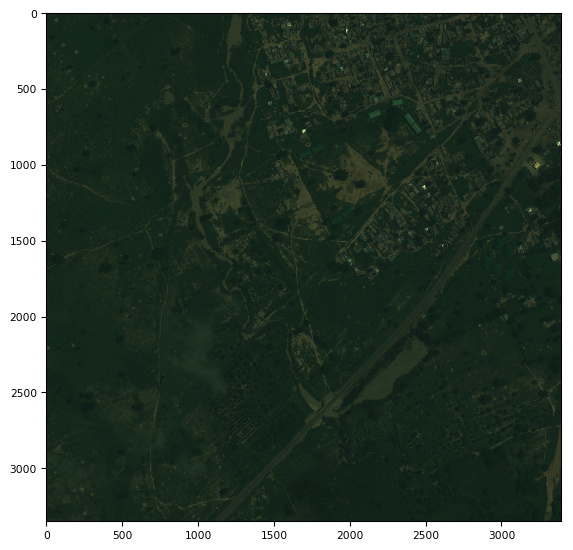

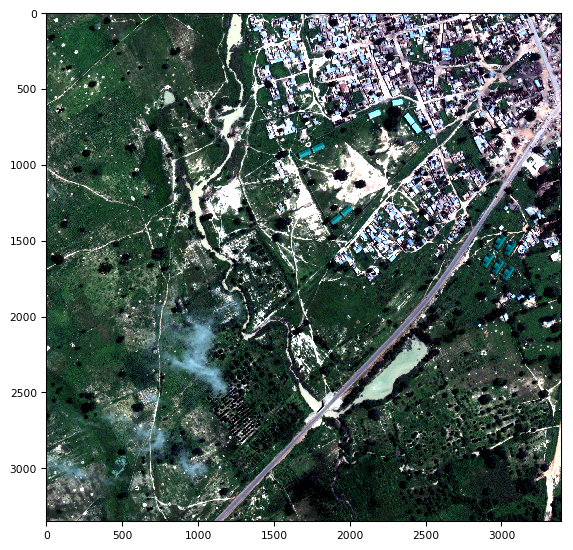

In [82]:
# trying drawing sth.
try_img_rgb = tiff.imread('{}/three_band/{}.tif'.format(DATA_DIR, '6100_2_2')).transpose([1, 2, 0])

tiff.imshow(try_img_rgb) # bad display
tiff.imshow(255 * scale_percentile(try_img_rgb)) # good display

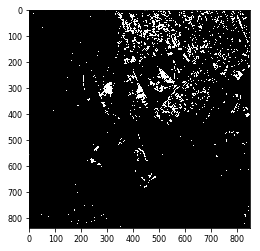

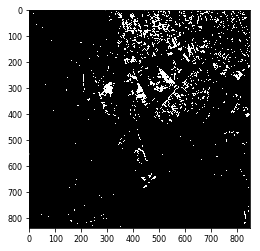

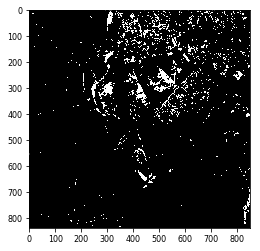

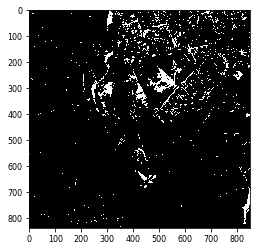

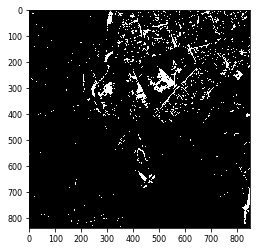

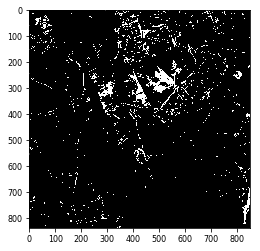

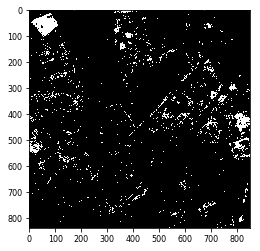

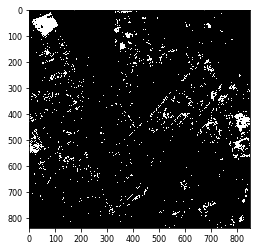

In [97]:
# 16通道中不同通道有不同的图像
try_img_M = tiff.imread('{}/sixteen_band/{}_M.tif'.format(DATA_DIR, '6100_2_2')).transpose([1, 2, 0])
try_img_M_ = stretch_n(try_img_M)
for i in range(8):
    show(try_img_M_[:, :, i])

In [98]:
try_img_M.shape

(837, 848, 8)

(<matplotlib.figure.Figure at 0x7f4ff1a0bba8>,
 <matplotlib.image.AxesImage at 0x7f4ff1bc0828>)

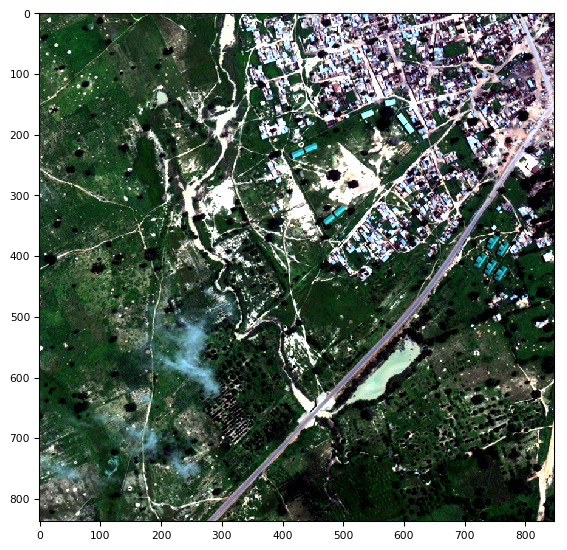

In [100]:
# 可以从16通道中提取RGB，然后组合成常见的RGB图像展示

try_img_M_RGB = np.zeros((837, 848, 3))
try_img_M_RGB[:, :, 0] = try_img_M[:, :, 4] # red
try_img_M_RGB[:, :, 1] = try_img_M[:, :, 2] # green
try_img_M_RGB[:, :, 2] = try_img_M[:, :, 1] # blue

tiff.imshow(255 * scale_percentile(try_img_M_RGB))

## Generator

In [177]:
def gen(batch_size=32):
    idx = 0
    X = np.zeros((batch_size, SLIDING_WIDTH, SLIDING_HEIGHT, 20), dtype=np.uint8)
    y = np.zeros((batch_size, SLIDING_WIDTH, SLIDING_HEIGHT, 1), dtype=np.uint8)
    # generator需要直接返回一个numpy array，而不是一个python list，除非Capacha那种情况，输入或输出确实是一个**list**
#     count, X, y = 0, [], []
    
    while True:
        img_id = random.choice([_ for _ in class_image_ids])

        wkt_info = train_wkt[train_wkt.ImageId==img_id]
        if wkt_info.shape[0] == 0:
            continue

        polygons_text = wkt_info.MultipolygonWKT.iloc[0]
        _, Xmax, Ymin  = grid_sizes.loc[grid_sizes.ImageId==img_id].iloc[0]
        img_rgb = tiff.imread('{}/three_band/{}.tif'.format(DATA_DIR, img_id)).transpose([1, 2, 0])
        
        w_pos, h_pos = random.random(), random.random()
        mask = get_mask(img_id, polygons_text, IMG_WIDTH, IMG_HEIGHT, Xmax, Ymin, w_pos, h_pos)
        
        if mask.sum().sum() == 0:
            continue

        img_A = tiff.imread('{}/sixteen_band/{}_A.tif'.format(DATA_DIR, img_id)).transpose([1, 2, 0])
        img_M = tiff.imread('{}/sixteen_band/{}_M.tif'.format(DATA_DIR, img_id)).transpose([1, 2, 0])
        img_P = tiff.imread('{}/sixteen_band/{}_P.tif'.format(DATA_DIR, img_id))
        img = get_img(img_id, img_rgb, img_A, img_M, img_P, w_pos, h_pos)

        X[idx, :] = img
        y[idx, :] = mask
        idx += 1
        
        if idx >= batch_size:
            idx = 0
            yield X, y

#         count += 1
#         X.append(img)
#         y.append(mask)
#         if count >= batch_size:
#             yield X, y
            
#             count = 0
#             X = []
#             y = []

In [160]:
from keras import backend as K
smooth = 1e-12

def jaccard_coef(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

# def jaccard_loss(y_true, y_pred):
#     return -jaccard_coef(y_true, y_pred)

def jaccard_coef_int(y_true, y_pred):
    # __author__ = Vladimir Iglovikov
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

Using TensorFlow backend.


## U-Net Models

In [174]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras import backend as K

def get_unet():
    inputs = Input((SLIDING_WIDTH, SLIDING_HEIGHT, 20))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer='Adadelta', loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
#     model.compile(optimizer='Adadelta', loss='jaccard_loss', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

    return model

def get_unet_complex():
    inputs = Input((SLIDING_WIDTH, SLIDING_HEIGHT, 20))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer='Adadelta', loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
#     model.compile(optimizer='Adadelta', loss='jaccard_loss', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

    return model

In [175]:
model = get_unet()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 256, 20)  0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 256, 256, 64)  11584       input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 256, 256, 64)  36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 128, 128, 64)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

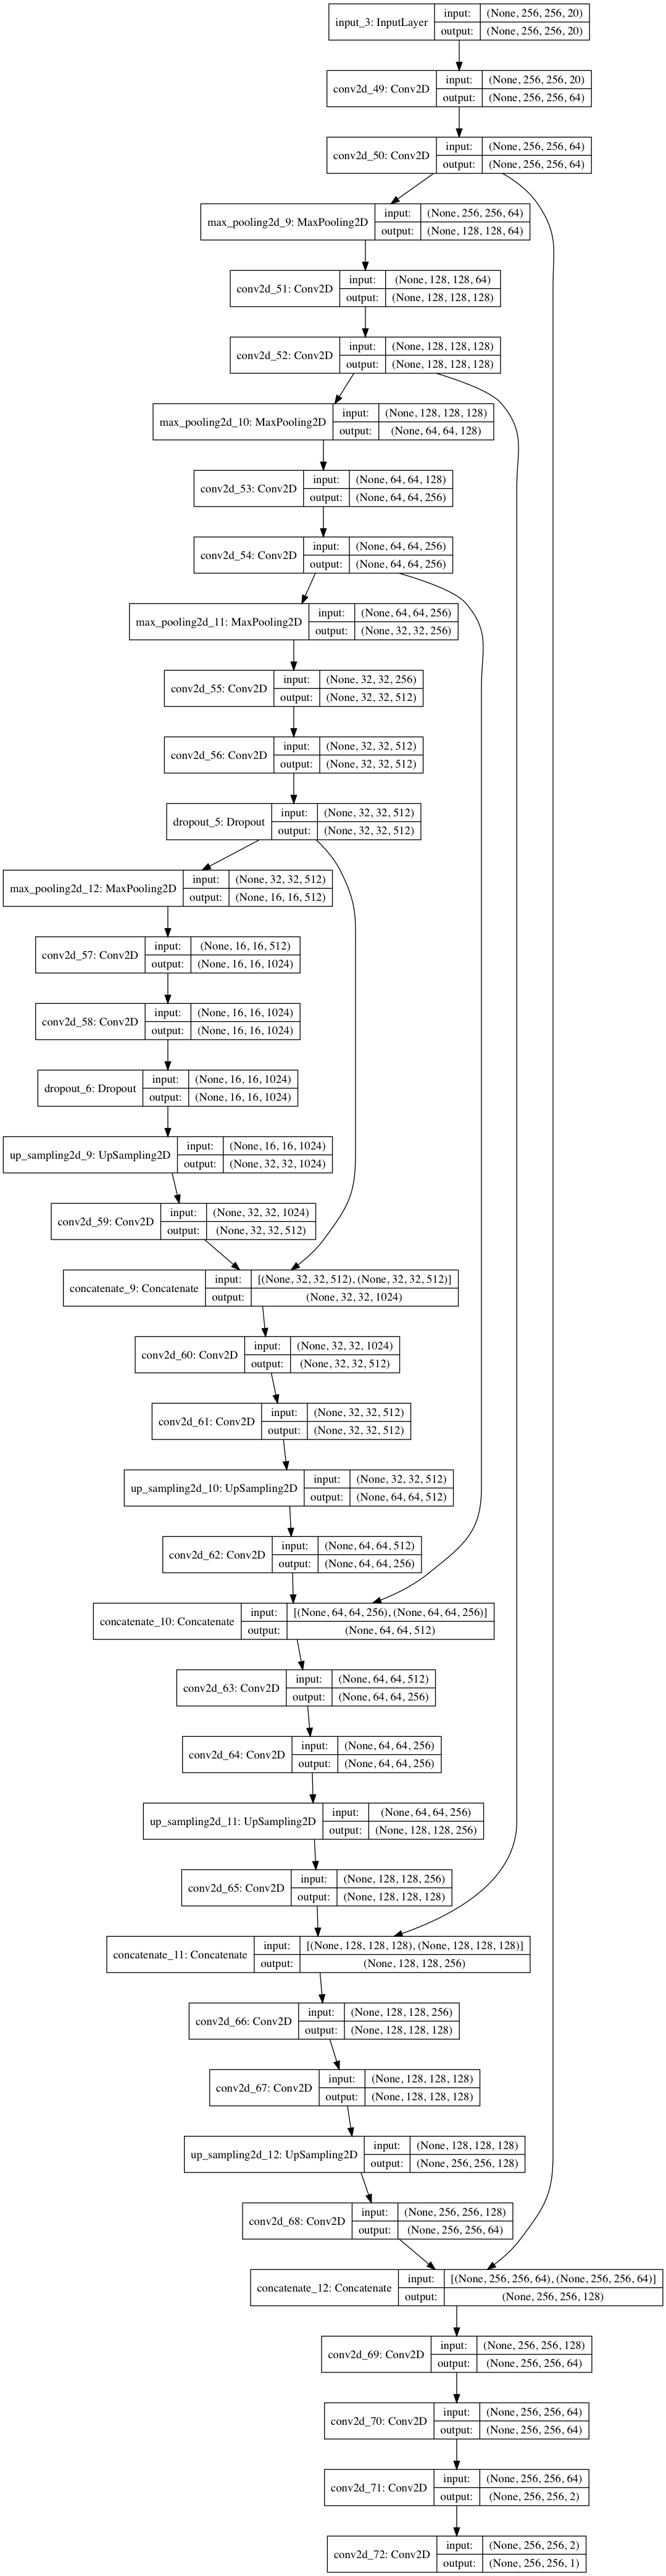

In [10]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file="/tmp/model.png", show_shapes=True)
Image('/tmp/model.png')

In [ ]:
from keras.callbacks import *

model = get_unet()
# model = get_unet_complex()
#model.summary()

RUN = RUN + 1 if 'RUN' in locals() else 1
LOG_DIR = '/output/training_logs/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

train_history = model.fit_generator(gen(batch_size=8), steps_per_epoch=8, epochs=128, verbose=1,
                                    validation_data=gen(2), validation_steps=2,
                                   callbacks=[tensorboard, checkpoint, early_stopping])

## 机器学习方法

In [200]:
batch_size = 5
generator = gen(batch_size=batch_size)
X_all_raw, y_all_raw = next(generator)

X_all = np.reshape(X_all_raw, (-1, 20))
y_all = np.reshape(y_all_raw, (-1, 1)).ravel()

In [201]:
X_all_raw.shape, y_all_raw.shape, X_all.shape, y_all.shape

((5, 256, 256, 20), (5, 256, 256, 1), (327680, 20), (327680,))

In [202]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

#bad input shape (7, 65536)
cv = ShuffleSplit(test_size=0.3)
score = cross_val_score(LogisticRegression(), X_all, y_all, scoring='accuracy', cv=cv).mean()

print(score)

0.96389465332


In [203]:
lr = LogisticRegression()
lr.fit(X_all, y_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

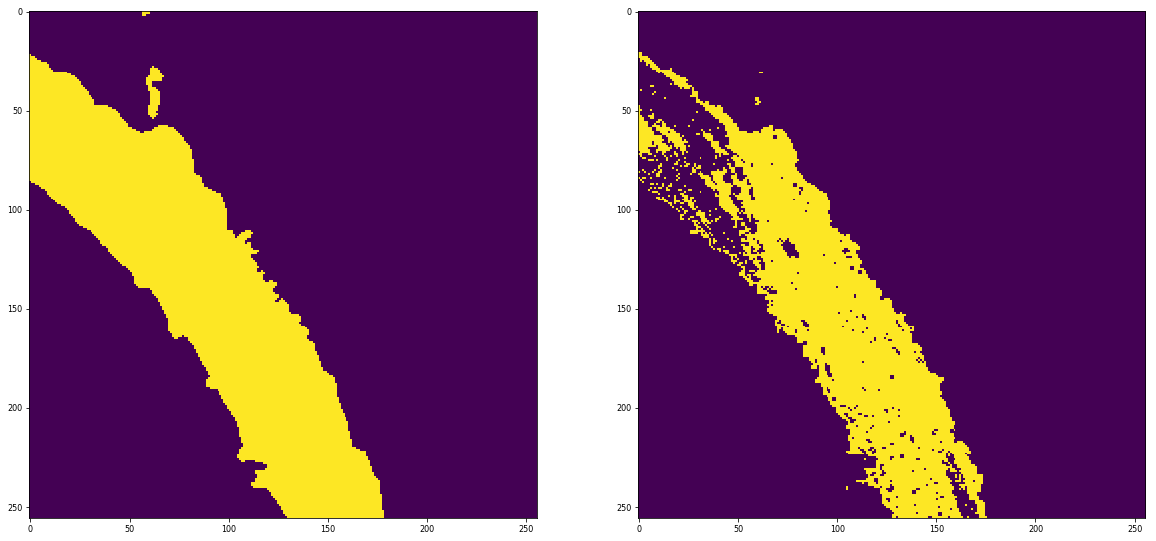

In [208]:
X_test, y_test = next(gen(1))
X_test = np.reshape(X_test, (-1, 20))
y_pred = lr.predict(X_test)

fig, axis = plt.subplots(1, 2, figsize=(20, 10))
axis[0].imshow(np.reshape(y_test, (256,256)))
axis[1].imshow(np.reshape(y_pred, (256,256)))